In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os
import glob

In [2]:
def read_a_file(file_path):
    
    df = pd.read_csv(file_path, skiprows=15, delimiter=",", index_col=False)
    # convert voltage signal to current signal by dividing with Rf = 20k Ohm
    df['CH1_I'] = df['CH1'] * 50
    # convert 
    df['TIME'] = df['TIME'] * 1000000
    df.rename(columns={'TIME': f"{file_path.split('/')[-1].split('.')[0]}_time", 
                       'CH1': f"{file_path.split('/')[-1].split('.')[0]}_volt", 
                       'CH1_I': f"{file_path.split('/')[-1].split('.')[0]}_current"}, 
              inplace=True)
    return df

In [3]:
# Define a Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))


def multi_gaussian(x, *params):
    n = len(params) // 3
    y = np.zeros_like(x)
    for i in range(n):
        A = params[i * 3]
        mu = params[i * 3 + 1]
        sigma = params[i * 3 + 2]
        y += gaussian(x, A, mu, sigma)
    return y

In [4]:
whole_df = pd.DataFrame()
data_files = glob.glob('QC_lab/*.CSV')
data_files.sort()
filenames = [name.split('/')[-1].split('.')[0] for name in data_files]

for file_path in data_files:
    df = read_a_file(file_path)
    
    whole_df = pd.concat([whole_df, df], axis=1)

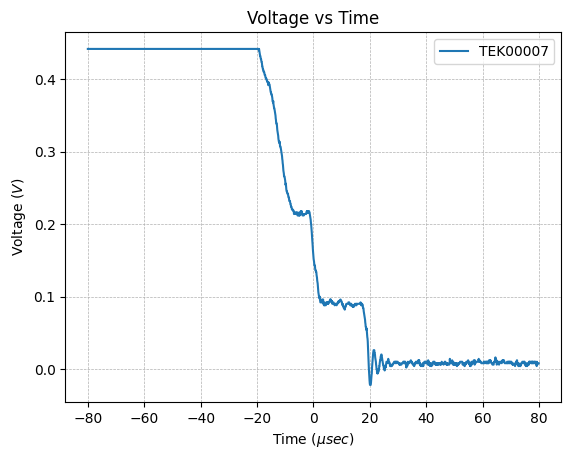

In [26]:
for file in filenames[7:8]:
    plt.plot(whole_df[f"{file}_time"], whole_df[f"{file}_volt"], '-', markersize=1, label=f'{file}')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Time ($\mu sec$)')
plt.ylabel('Voltage ($V$)')
plt.title('Voltage vs Time')
plt.legend()
plt.savefig('signal_one.png', dpi=300)

Text(0.5, 1.0, 'Histogram for 1 measurement')

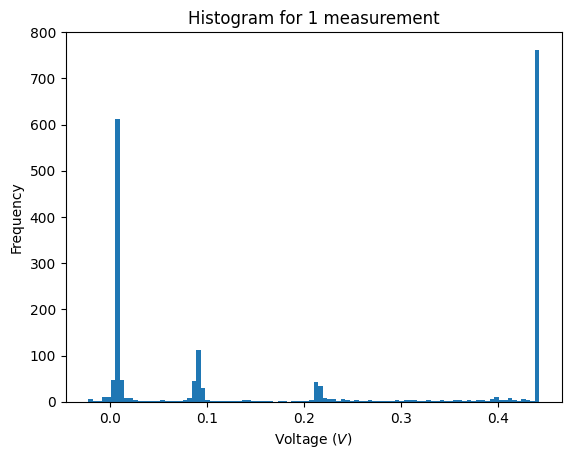

In [6]:
plt.hist(whole_df["TEK00007_volt"], bins=100, alpha=1.0)
plt.xlabel('Voltage ($ V$)')
plt.ylabel('Frequency')
plt.title('Histogram for 1 measurement')
# plt.savefig('histogram_one.png', dpi=300)

In [7]:
hist_data = pd.DataFrame()

for file in filenames:
    if int(file[-2:]) in [2, 13, 23, 12, 22, 14, 24, 6, 16, 26]:
        hist_data = pd.concat([hist_data, whole_df[f"{file}_volt"]], axis=0, ignore_index=True)

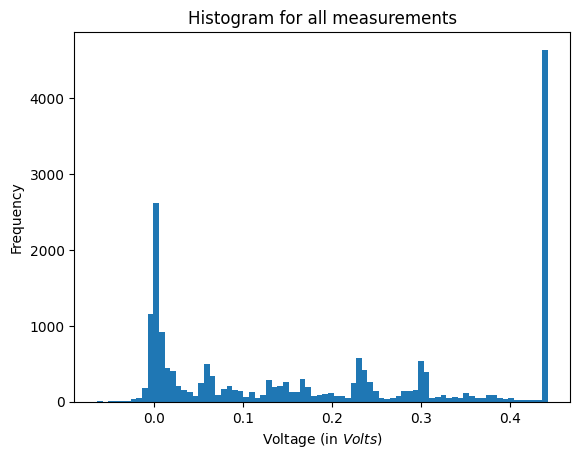

In [8]:
plt.hist(hist_data[0], bins=80, alpha=1.0)
plt.xlabel('Voltage (in $Volts$)')
plt.ylabel('Frequency')
plt.title('Histogram for all measurements')
plt.savefig('histogram_all.png', dpi=300)

In [9]:
# Generate histogram data
voltages = hist_data[0]
voltages = voltages[~np.isnan(voltages)]
hist_data, bin_edges = np.histogram(voltages, bins=100)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])


In [10]:
# Fit the histogram data
ranges = [(-0.1, 0.1), (0.03, 0.1), (0.1, 0.2), (0.2, 0.26), (0.26, 0.34)]
bin_centers_ = {}
params = {}

for i, limit in enumerate(ranges):
    selected_indices = (bin_centers >= limit[0]) & (bin_centers <= limit[1])
    bin_centers_[i] = bin_centers[selected_indices]
    selected_hist_data = hist_data[selected_indices]
    initial_guess = [max(selected_hist_data), bin_centers_[i][np.argmax(selected_hist_data)], 0.02]
    params[i], covariance = curve_fit(gaussian, bin_centers_[i], selected_hist_data, p0=initial_guess)


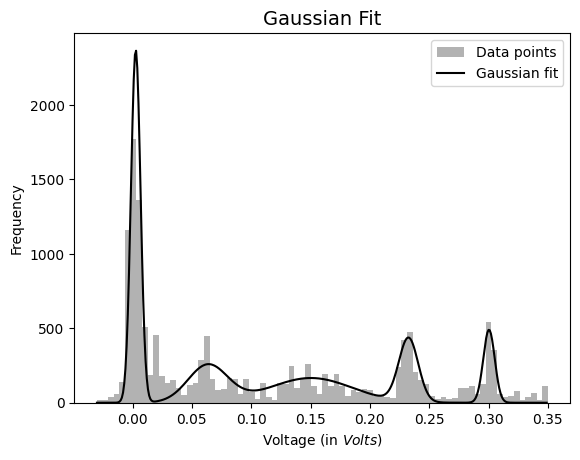

In [11]:
# Plot the fit
plt.hist(voltages, range=(-0.03, 0.35), bins=80, alpha=0.6, label='Data points', color='grey')

# for param in params.values():
bin_centers = np.arange(-0.03, 0.35, 0.001)

plt.plot(bin_centers, gaussian(bin_centers, *params[0])+gaussian(bin_centers, *params[1])+
         gaussian(bin_centers, *params[2])+gaussian(bin_centers, *params[3])+gaussian(bin_centers, *params[4]), color='black',label="Gaussian fit")

# plt.axvline(x=params[0][1], color='blue', linestyle='--', label=f'$V_0 = {params[0][1]:.2f} V$')
# plt.axvline(x=params[1][1], color='red', linestyle='--', label=f'$V_1 = {params[1][1]:.2f} V$')
# plt.axvline(x=params[2][1], color='green', linestyle='--', label=f'$V_2 = {params[2][1]:.2f} V$')
# plt.axvline(x=params[3][1], color='purple', linestyle='--', label=f'$V_3 = {params[3][1]:.2f} V$')
# plt.axvline(x=params[4][1], color='black', linestyle='--', label=f'$V_4 = {params[4][1]:.2f} V$')

plt.xlabel('Voltage (in $Volts$)')
plt.ylabel('Frequency')
plt.title('Gaussian Fit', fontsize=14)
plt.legend()
plt.savefig('gaussian_fit.png', dpi=300)

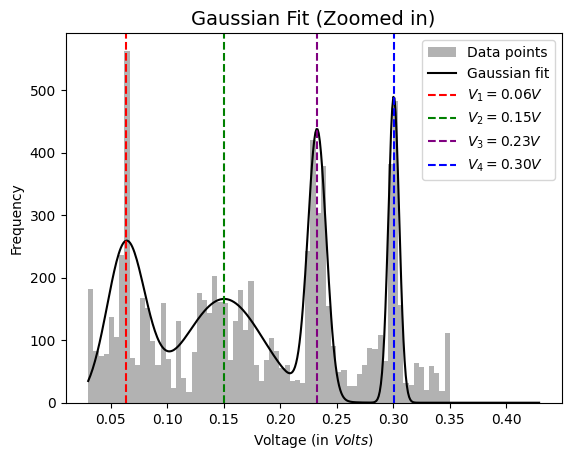

In [30]:
# Plot the zoomed fit
plt.hist(voltages, range=(0.03, 0.35), bins=70, alpha=0.6, label='Data points', color='grey')

# for param in params.values():
bin_centers = np.arange(0.03, 0.43, 0.001)

plt.plot(bin_centers, gaussian(bin_centers, *params[0])+gaussian(bin_centers, *params[1])+
         gaussian(bin_centers, *params[2])+gaussian(bin_centers, *params[3])+gaussian(bin_centers, *params[4]), color="black", label="Gaussian fit")

# plt.axvline(x=params[0][1], color='blue', linestyle='--', label=f'$V_0 = {params[0][1]:.2f} V$')
plt.axvline(x=params[1][1], color='red', linestyle='--', label=f'$V_1 = {params[1][1]:.2f} V$')
plt.axvline(x=params[2][1], color='green', linestyle='--', label=f'$V_2 = {params[2][1]:.2f} V$')
plt.axvline(x=params[3][1], color='purple', linestyle='--', label=f'$V_3 = {params[3][1]:.2f} V$')
plt.axvline(x=params[4][1], color='blue', linestyle='--', label=f'$V_4 = {params[4][1]:.2f} V$')

plt.xlabel('Voltage (in $Volts$)')
plt.ylabel('Frequency')
plt.title('Gaussian Fit (Zoomed in)', fontsize=14)
plt.legend()
plt.savefig('gaussian_fit_zoomed.png', dpi=300)

In [19]:
# calculating average voltage steps along with the standard deviation

def std_(*std):
    return np.sqrt(sum([i**2 for i in std]))/len(std)

def steps(V1, V2):
    return np.abs(V1 - V2)

V_steps = []
V_std = []

for i in range(len(params)-1):
    
    V_steps.append(steps(params[i][1], params[i+1][1]))
    V_std.append(std_(params[i][2], params[i+1][2]))

V_step_avg = np.mean(V_steps)
avg_std = std_(*V_std)

In [34]:
V_steps

[np.float64(0.060788901963517966),
 np.float64(0.08680612731071749),
 np.float64(0.08227525680981448),
 np.float64(0.06784090264709786)]

/var/folders/n2/30p6hmss7cn12_xf4gjxdk740000gn/T/ipykernel_3606/3646345710.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


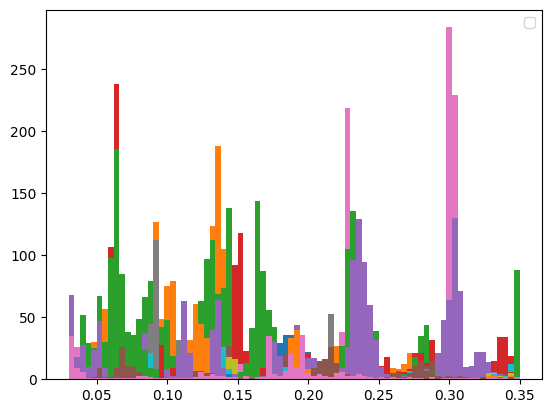

In [24]:
for file in filenames:
    
    # if int(file[-2:]) in [13, 23, 12, 22, 14, 24, 6, 16, 26]:
    plt.hist(whole_df[file + "_volt"], range=(0.03, 0.35), bins=80)

plt.legend()

/var/folders/n2/30p6hmss7cn12_xf4gjxdk740000gn/T/ipykernel_3606/4019276169.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


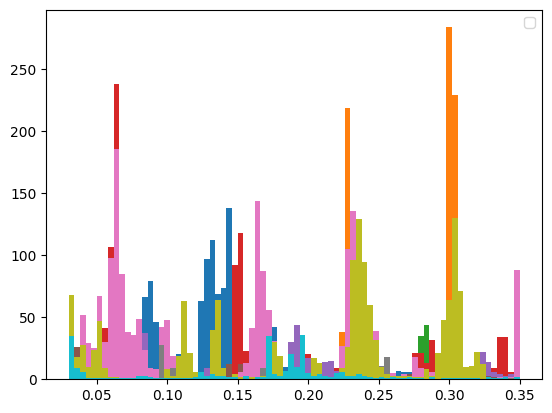

In [23]:
for file in filenames:
    
    if int(file[-2:]) in [2, 13, 23, 12, 22, 14, 24, 6, 16, 26]:
        plt.hist(whole_df[file + "_volt"], range=(0.03, 0.35), bins=80)

plt.legend()